In [1]:
%load_ext autoreload
%autoreload 2

# ESM1.6 Scaling

End-to-end pipeline generating scaling plots for [ESM1.6 Pre-industrial configuration](https://github.com/ACCESS-NRI/access-esm1.6-configs/tree/dev-preindustrial%2Bconcentrations).

## Setup
The following variables control where the configurations and model run outputs are saved.

In [2]:
import os
import getpass

from pathlib import Path

username = getpass.getuser()
defaultproject = os.environ.get("PROJECT")

# CHANGE test_path to where you're comfortable dumping model run information
test_path = f"/scratch/{defaultproject}/{username}/access_models_scaling_results"

# Name of the experiment
model_type = "access-esm1.6"
test_path = f"{model_type}_scaling_layouts"
repository_directory = f"{model_type}-PI-config"
config_yaml_name=f"{test_path}/{model_type}_layout_input_config.yaml"

# Since we have already generated and run *all* the experiments, we
# set both of these variables to False, to avoid re-generating and/or re-running them.
generate_experiments = False
run_experiments = False

In [3]:
# Create profiling manager
from access.profiling import ESM16Profiling
esm_profiling = ESM16Profiling(Path(test_path))

## Generate experiments

We will perform a simple scaling study, varying the total number of nodes used over `[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]`. We will search for different layouts that closely match a scaled 4-node releaed PI config. 

In [4]:
def get_node_configs():
    from access.config.esm1p6_layout_input import LayoutSearchConfig

    num_nodes_list = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]
    tol_around_ctrl_ratio = [0.05]*len(num_nodes_list)
    max_wasted_ncores_frac=[0.1 if x <= 1 else 0.05 if x <=3 else 0.02 for x in num_nodes_list]
    scaling_configs = [LayoutSearchConfig(tol_around_ctrl_ratio=t, max_wasted_ncores_frac=m) for t, m in zip(tol_around_ctrl_ratio, max_wasted_ncores_frac)]

    return num_nodes_list, scaling_configs

In [5]:

def generate_esm1p6_layouts() -> str:
    import sys

    from access.config.esm1p6_layout_input import generate_esm1p6_core_layouts_from_node_count, generate_esm1p6_perturb_block

    control_expriment_name = "Control_Experiment"
    generator_config_prefix = f"""
model_type: {model_type}
repository_url: git@github.com:ACCESS-NRI/{model_type}-configs.git
start_point: 1ebd393 # the commit hash that access-bot refers to when committing the new checksums

test_path: {test_path}
repository_directory: {repository_directory}

control_branch_name: ctrl

{control_expriment_name}:
    config.yaml:
        walltime: Inf
        modules:
            use:
                - /g/data/{defaultproject}/{username}/spack/0.22/release/modules/linux-rocky8-x86_64_v4
            load:
                - access-esm1p6/2025.09.002    

        manifest:
            reproduce:
                exe: False    # cice5 has to be manually compiled because the runtime core counts is set at compile time
        repeat: True
        runspersub: 10

Perturbation_Experiment:
"""

    blocknum = 1
    queue = "normalsr"
    branch_name_prefix = "esm1p6-layout"
    entire_block = generator_config_prefix
    num_nodes_list, scaling_configs = get_node_configs()
    # num_nodes_list = [4.0]
    # from access.config.esm1p6_layout_input import LayoutSearchConfig
    # scaling_configs = [LayoutSearchConfig(tol_around_ctrl_ratio=None, max_wasted_ncores_frac=0.02)]*len(num_nodes_list)

    seen_layouts = set()
    walltime_hrs = 0.0
    for num_nodes, config in zip(num_nodes_list, scaling_configs, strict=True):
        layout = generate_esm1p6_core_layouts_from_node_count(
            num_nodes,
            queue=queue,
            layout_search_config=config,
        )[0]
        if not layout:
            print(f"No layouts found for {num_nodes} nodes", file=sys.stderr)
            continue

        layout = [x for x in layout if x not in seen_layouts]
        seen_layouts.update(layout)
        print(f"Generated {len(layout)} layouts for {num_nodes} nodes. Layouts: {layout}")

        branch_name = f"{branch_name_prefix}-unused-cores-to-cice-{config.allocate_unused_cores_to_ice}"
        prev_blocknum = blocknum
        block, blocknum = generate_esm1p6_perturb_block(
            num_nodes, layout, branch_name, queue=queue, start_blocknum=blocknum,
        )
        nblocks_added = blocknum - prev_blocknum
        walltime_hrs += nblocks_added * (1.5 * 4.0/num_nodes) # use a 1.5 hrs time for 4-node runs, and then scale linearly
        entire_block += block

    entire_block = entire_block.replace("walltime: Inf", f"walltime: {int(walltime_hrs)}:00:00")

    return entire_block

## Generate the config and write into a file


In [6]:
# Generate the configuration and write to file
generator_config = generate_esm1p6_layouts()

with open(config_yaml_name, "w") as f:
    f.write(generator_config)
print(f"Generator config written to {config_yaml_name}")

Min. total cores required for a valid config (94) should be greater than the number of ATM + OCN cores (101). Currently, any config that satisfies the ATM + OCN core requirements will also satisfy the requirement for the min. total cores
Min. total cores required for a valid config (198) should be greater than the number of ATM + OCN cores (202). Currently, any config that satisfies the ATM + OCN core requirements will also satisfy the requirement for the min. total cores
Min. total cores required for a valid config (297) should be greater than the number of ATM + OCN cores (303). Currently, any config that satisfies the ATM + OCN core requirements will also satisfy the requirement for the min. total cores


Generated 2 layouts for 1.0 nodes. Layouts: [LayoutTuple(atm_nx=8, atm_ny=6, mom_nx=8, mom_ny=6, ice_ncores=3), LayoutTuple(atm_nx=8, atm_ny=6, mom_nx=9, mom_ny=5, ice_ncores=3)]
Generated 4 layouts for 2.0 nodes. Layouts: [LayoutTuple(atm_nx=10, atm_ny=10, mom_nx=10, mom_ny=10, ice_ncores=6), LayoutTuple(atm_nx=10, atm_ny=10, mom_nx=11, mom_ny=9, ice_ncores=6), LayoutTuple(atm_nx=10, atm_ny=10, mom_nx=12, mom_ny=8, ice_ncores=6), LayoutTuple(atm_nx=12, atm_ny=8, mom_nx=12, mom_ny=8, ice_ncores=6)]
Generated 3 layouts for 3.0 nodes. Layouts: [LayoutTuple(atm_nx=14, atm_ny=11, mom_nx=12, mom_ny=12, ice_ncores=9), LayoutTuple(atm_nx=14, atm_ny=11, mom_nx=13, mom_ny=11, ice_ncores=9), LayoutTuple(atm_nx=14, atm_ny=11, mom_nx=14, mom_ny=10, ice_ncores=9)]
Generated 3 layouts for 4.0 nodes. Layouts: [LayoutTuple(atm_nx=16, atm_ny=13, mom_nx=14, mom_ny=14, ice_ncores=12), LayoutTuple(atm_nx=16, atm_ny=13, mom_nx=15, mom_ny=13, ice_ncores=12), LayoutTuple(atm_nx=16, atm_ny=13, mom_nx=16, mom_

In [7]:
from experiment_generator.experiment_generator import ExperimentGenerator
from ruamel.yaml import YAML

ryaml = YAML()
ryaml.preserve_quotes = True

config_dict = ryaml.load(generator_config)

if generate_experiments:
    expgen = ExperimentGenerator(config_dict)
    expgen.run()

## Running the model

Next get a list of all the new branches and generate the experiments 

In [8]:

if not run_experiments:
    print("Skipping running experiments.")
    all_branches = ['esm1p6-layout-unused-cores-to-cice-False_atm_8x6_mom_8x6_ice_3x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_16x13_mom_15x13_ice_12x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_16x16_mom_16x15_ice_15x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_18x17_mom_18x16_ice_18x1', 
                    'esm1p6-layout-unused-cores-to-cice-False_atm_20x20_mom_22x18_ice_24x1']
else:
    pe_expts = config_dict["Perturbation_Experiment"]
    all_branches = [x for k in pe_expts for x in pe_expts[k]["branches"]]

esm_profiling.generate_experiments(all_branches)

Skipping running experiments.


In [9]:
# Helper function to mark all NEW experiments as DONE
def mark_experiments_done(esm_prof: ESM16Profiling):
    from access.profiling.manager import ProfilingExperimentStatus
    for path, exp in esm_prof.experiments.items():
        if exp.status == ProfilingExperimentStatus.NEW:
            exp.status = ProfilingExperimentStatus.DONE

if run_experiments:
    esm_profiling.nruns = 3 # Each run is repeated three times.
    esm_profiling.run_experiments()
else:
    mark_experiments_done(esm_profiling)

## Parsing and plotting experiment results


In [10]:
esm_profiling.parse_scaling_data()

Multiple payu json logs found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_8x6_mom_8x6_ice_3x1/config! Using the first one found.
Multiple output directories found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_8x6_mom_8x6_ice_3x1/config! Using the first one found.
Multiple payu json logs found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1/config! Using the first one found.
Multiple output directories found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_10x10_mom_10x10_ice_6x1/config! Using the first one found.
Multiple payu json logs found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1/config! Using the first one found.
Multiple output directories found in access-esm1.6_scaling_layouts/esm1p6-layout-unused-cores-to-cice-False_atm_14x11_mom_12x12_ice_9x1/config! Using the first one f

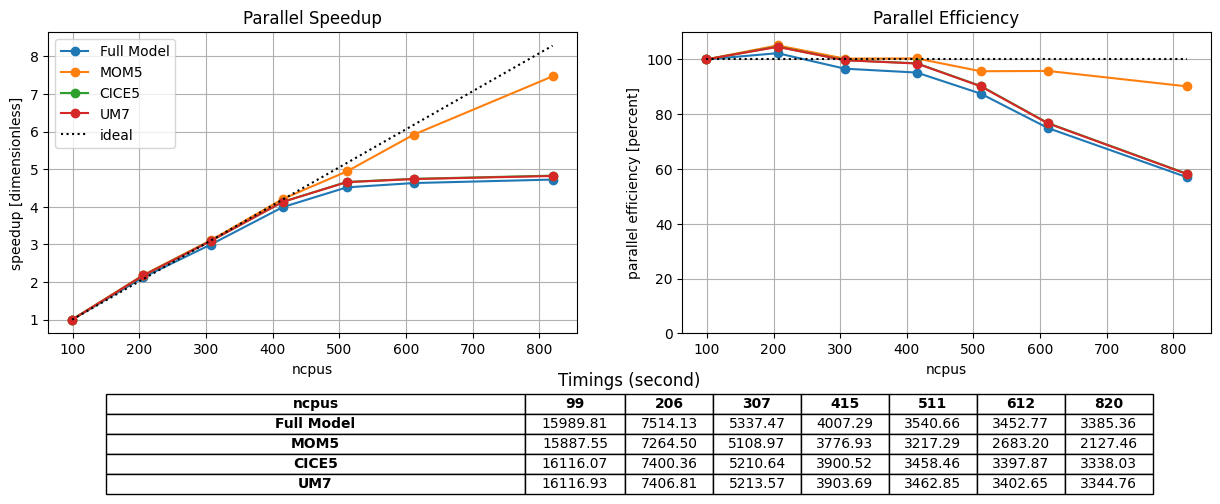

In [11]:
from access.profiling.metrics import tmax

esm_profiling.plot_scaling_data(
    components=["payu", "MOM5", "CICE5", "UM_Total_Walltime"],
    regions=[
        ["payu_model_run_duration_seconds"],
        ["Ocean"],
        ["Total"],
        ["um_total_walltime"],
    ],
    metric=tmax,
    region_relabel_map={
        "payu_model_run_duration_seconds": "Full Model",
        "Ocean": "MOM5",
        "Total": "CICE5",
        "um_total_walltime": "UM7",
    }
)

## Scaling table for the best config per node

| Num. nodes (Ncores used) | Walltime (speedup) | ATM ncores (speedup) | MOM ncores (speedup) | ICE ncores (speedup) |
|--------------------------|--------------------|----------------------|----------------------|----------------------|
|            1 (  99)      |    15973.8 ( 1.0x) |           48 ( 1.0x) |           48 ( 1.0x) |            3 ( 1.0x) |
|            2 ( 206)      |     7486.1 ( 2.1x) |          100 ( 2.1x) |          100 ( 2.1x) |            6 ( 2.1x) |
|            3 ( 307)      |     5315.9 ( 3.0x) |          154 ( 3.0x) |          144 ( 3.0x) |            9 ( 3.0x) |
|            4 ( 415)      |     3979.8 ( 4.0x) |          208 ( 4.1x) |          195 ( 4.0x) |           12 ( 4.1x) |
|            5 ( 511)      |     3519.2 ( 4.5x) |          256 ( 4.6x) |          240 ( 4.5x) |           15 ( 4.6x) |
|            6 ( 612)      |     3430.4 ( 4.7x) |          306 ( 4.7x) |          288 ( 4.7x) |           18 ( 4.7x) |
|            8 ( 820)      |     3362.0 ( 4.8x) |          400 ( 4.8x) |          396 ( 4.8x) |           24 ( 4.9x) |